In [1]:
# setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras.datasets.cifar10 as c10
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.utils import shuffle
# 1. load data
(x_train, y_train), (x_test, y_test) = c10.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
# 2. normalize data
max_value = np.max(x_train.flatten())
x_train = np.divide(x_train, max_value)
x_test = np.divide(x_test, max_value)
# 3. shuffle data
x_train = shuffle(x_train)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [2]:
# 4. create autoencoder
class AutoEncoder(Model):
    def __init__(self, latent_dim):
        super(AutoEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.InputLayer((32,32,3)),
            layers.Flatten(),
            # layers.Conv2D(3,3,activation="relu"),
            # layers.MaxPool2D(pool_size=(2,2)),
            # layers.Conv2D(3,3,activation="relu"),
            # layers.MaxPool2D(pool_size=(2,2)),
            layers.Dense(latent_dim, activation="relu")
        ])
        # 3072 images with size 6x6
        self.decoder = tf.keras.Sequential([
            layers.Dense((32*32*3), activation="sigmoid"),
            # layers.Conv2DTranspose(3, kernel_size=2, strides=2, activation="relu", padding="same", output_padding=1),
            # layers.Conv2DTranspose(3, kernel_size=3, strides=3, activation="sigmoid", padding="same", output_padding=1),
            layers.Reshape((32,32,3))
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 5. compiling and training    
AE = AutoEncoder(100)
AE.compile(optimizer="adam", loss=losses.MeanSquaredError())
AE.fit(x_train, x_train, epochs=1, validation_data=(x_test, x_test))
AE.summary()

1563/1563 [==============================] - 8s 5ms/step - loss: 0.0293 - val_loss: 0.0221
Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 100)               307300    
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         310272    
                                                                 
Total params: 617,572
Trainable params: 617,572
Non-trainable params: 0
_________________________________________________________________


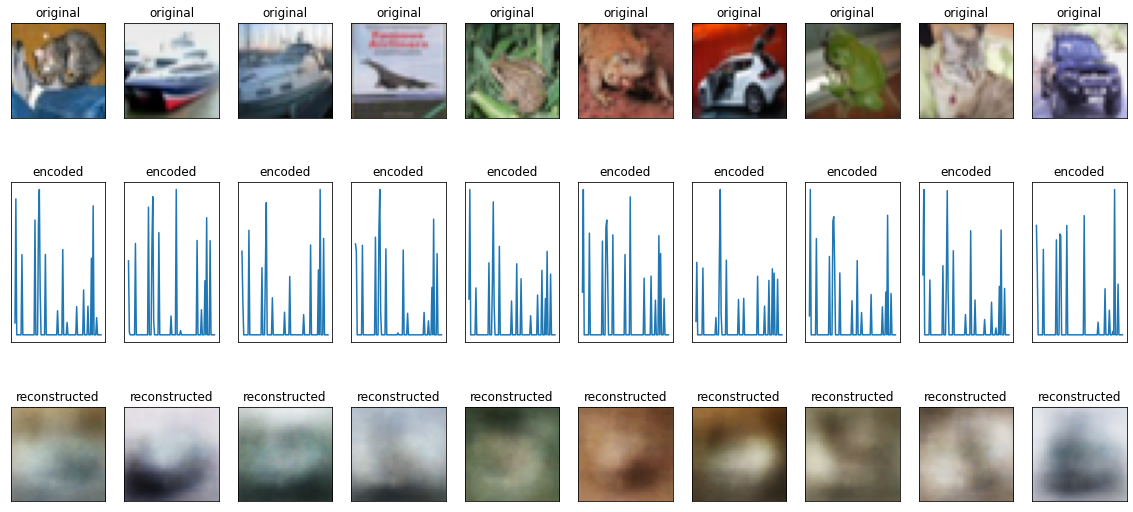

In [3]:
# 6. results

encoded_imgs = AE.encoder(x_test).numpy()
decoded_imgs = AE.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded
    ax = plt.subplot(3, n, i + 1 + n)
    plt.plot(range(100),encoded_imgs[i])
    plt.title("encoded")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [4]:
ECG5000_train = pd.read_fwf(".\ECG5000\ECG5000_TEST.txt", header=None) # 4500
ECG5000_test = pd.read_fwf(".\ECG5000\ECG5000_TRAIN.txt", header=None) # 500
ECG5000 = pd.concat([ECG5000_train, ECG5000_test])
# make train healthy and test abnormal
ECG5000_normal = ECG5000.values[ECG5000.values[:,0]==1]
ECG5000_abnormal = ECG5000.values[ECG5000.values[:,0]!=1]

X_train = ECG5000_normal[:,1:]
Y_train = ECG5000_normal[:,0]
X_test = ECG5000.values[:,1:]
Y_test = ECG5000.values[:,0]
X_validation = ECG5000_abnormal[:,1:]
Y_validation = ECG5000_abnormal[:,0]
def shape():
    print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
max_value = abs(np.max((X_train.max(), X_test.max())))
min_value = abs(np.min((X_train.max(), X_test.max())))
X_train /= max_value
# X_train += min_value
X_test /= max_value
# X_test += min_value

class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(140, activation="sigmoid")
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
AD = AnomalyDetector()
AD.compile(optimizer="adam", loss="mae")
AD.fit(X_train, X_train, epochs=10, validation_data=(X_test, X_test), shuffle=True)
AD.summary()

Epoch 1/10
92/92 [==============================] - 1s 5ms/step - loss: 0.2557 - val_loss: 0.1047
Epoch 2/10
92/92 [==============================] - 0s 3ms/step - loss: 0.0747 - val_loss: 0.0963
Epoch 3/10
92/92 [==============================] - 0s 3ms/step - loss: 0.0679 - val_loss: 0.0860
Epoch 4/10
92/92 [==============================] - 0s 3ms/step - loss: 0.0646 - val_loss: 0.0803
Epoch 5/10
92/92 [==============================] - 0s 3ms/step - loss: 0.0635 - val_loss: 0.0786
Epoch 6/10
92/92 [==============================] - 0s 3ms/step - loss: 0.0623 - val_loss: 0.0781
Epoch 7/10
92/92 [==============================] - 0s 3ms/step - loss: 0.0608 - val_loss: 0.0773
Epoch 8/10
92/92 [==============================] - 0s 3ms/step - loss: 0.0604 - val_loss: 0.0751
Epoch 9/10
92/92 [==============================] - 0s 3ms/step - loss: 0.0601 - val_loss: 0.0744
Epoch 10/10
92/92 [==============================] - 0s 3ms/step - loss: 0.0599 - val_loss: 0.0739
Model: "anomaly_det

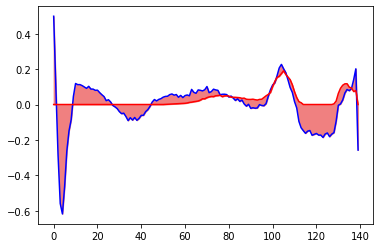

92/92 [==============================] - 0s 1ms/step


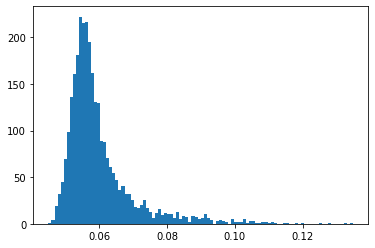

157/157 [==============================] - 0s 980us/step


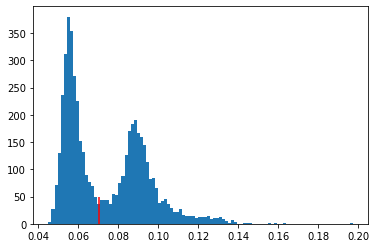

In [6]:
encoded_data = AD.encoder(X_train).numpy()
decoded_data = AD.decoder(encoded_data).numpy()

plt.plot(X_train[0], "b")
plt.plot(decoded_data[0], "r")
plt.fill_between(range(140), X_train[0], decoded_data[0], color="lightcoral")
plt.show()

reconstructions = AD.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions, X_train)

plt.hist(train_loss[None,:], bins=100)
plt.show()

threshold = np.mean(train_loss) + np.std(train_loss)

reconstructions2 = AD.predict(X_test)
test_loss = tf.keras.losses.mae(reconstructions2, X_test)

plt.hist(test_loss[None,:], bins=100)
plt.vlines(threshold, 0, 50, "red")
plt.show()